### Cab-Driver Agent

In [46]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pandas as pd

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from scipy.stats import zscore

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

## Test Rig for Environment 

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print(Time_matrix.shape)
print(Time_matrix[0][0][23][1])

(5, 5, 24, 7)
0.0


#### Test env

In [3]:
driver_env = CabDriver(debug=True)

CabDriver initialized with following config {'action_space': [(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 0)], 'state_space_length': 840, 'state_size': 36, 'total_reward': 0, 'total_time_consumed': 0, 'total_time_steps': 0, 'state_init': (1, 22, 6)}


In [4]:
# Check Requests
actions = driver_env.requests(driver_env.state_init)

# select random action
action = random.choice(actions)
print('Random Action Selected : ', action)

# Check Rewards Earned and Next state for random Action
next_state, reward, is_terminal = driver_env.step(driver_env.state_init,action)
print('Reward Value : ',reward)
print('Next State Value : ',next_state)
print('Is terminal : ',is_terminal)

# Check Rewards Earned and Next state for Action - (0,0) - Driver didn't take any request.
next_state, reward, is_terminal = driver_env.step(driver_env.state_init,(0,0))
print('Reward Value : ',reward)
print('Next State Value : ',next_state)
print('Is terminal : ',is_terminal)

state_encode = driver_env.encode_state_v1(driver_env.state_init)
state_encode.shape

possible actions:  (1, 22, 6)  ->  [(4, 2), (1, 2), (0, 0)]
Random Action Selected :  (4, 2)
step:  {'state': (1, 22, 6), 'action': (4, 2), 'time_spent_for_pickup': 3, 'pickup_hour': 1, 'pickup_day': 0, 'time_spent_for_ride': 5}
Reward Value :  5
Next State Value :  (2, 6, 6)
Is terminal :  False
step:  {'state': (1, 22, 6), 'action': (0, 0), 'time_spent_for_pickup': 8, 'pickup_hour': 6, 'pickup_day': 0, 'time_spent_for_ride': 0}
Reward Value :  -5
Next State Value :  (1, 23, 6)
Is terminal :  False
encode_state_v1:  (1, 22, 6)  ->  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]


(36,)

In [5]:
episode_num = [0]
accu_rewards = [0]
total_time = [0]
total_steps = [0]
episodes_max = 100

driver_env=CabDriver()

for i in range(1,episodes_max+1):
    driver_env.reset()
    state = driver_env.state_init
    is_terminal = False
    while not is_terminal:
        # random action selection
        actions = driver_env.requests(state)
        action = random.choice(actions)
        
        next_state, reward, is_terminal = driver_env.step(state, action)
        state = next_state
    
    tot_rewards, tot_time, steps = driver_env.tracking_info()
    episode_num.append(i)
    accu_rewards.append(tot_rewards)
    total_time.append(tot_time)
    total_steps.append(steps)
    
episodes_vs_rewards=pd.DataFrame(data={'Accumulated_Rewards':accu_rewards,
                                      'Total_Time':total_time,
                                      'Episode_Number':episode_num,
                                      'Total_Steps':total_steps})

In [6]:
episodes_vs_rewards.describe()

,Accumulated_Rewards,Total_Time,Episode_Number,Total_Steps
count,101.000000,101.000000,101.000000,101.000000
mean,-144.514851,716.455446,50.000000,127.524752
std,173.383714,72.060880,29.300171,15.505866
min,-645.000000,0.000000,0.000000,0.000000
25%,-267.000000,721.000000,25.000000,124.000000
50%,-142.000000,723.000000,50.000000,128.000000
75%,-22.000000,725.000000,75.000000,134.000000
max,258.000000,734.000000,100.000000,152.000000


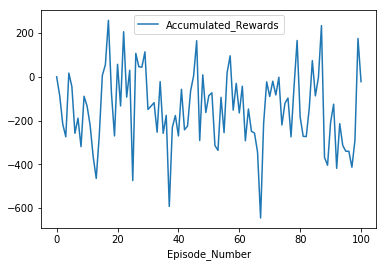

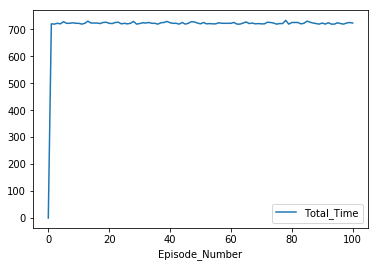

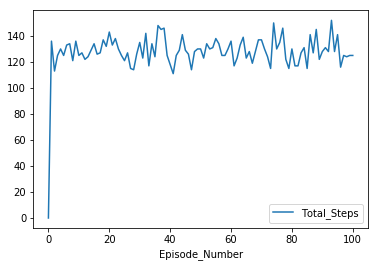

In [7]:
# Plot rewards vs Episodes
episodes_vs_rewards.plot(x='Episode_Number',y='Accumulated_Rewards')
episodes_vs_rewards.plot(x='Episode_Number',y='Total_Time')
episodes_vs_rewards.plot(x='Episode_Number',y='Total_Steps')

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size=None, action_size=None, discount_factor=0.95, learning_rate=0.01, 
                 epsilon_min=0., epsilon_max=1., epsilon_decay=-0.0001, batch_size=32, experience_buffer_size=2000,
                 debug=False, env=CabDriver()):
        # Define size of state and action
        if state_size is not None:
            self.state_size = state_size
        else:
            self.state_size = env.state_size

        if action_size is not None:
            self.action_size = action_size
        else:
            self.action_size = len(env.action_space)

        self.discount_factor = discount_factor
        self.learning_rate = learning_rate 
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.epsilon = epsilon_max
        self.epsilon_decay = epsilon_decay
        self.timestep = 0
        
        self.batch_size = batch_size        
        # create replay memory using deque
        self.memory = deque(maxlen=experience_buffer_size)
        
        self.debug = debug
        self.env = env
        
        if self.debug:
            print('DQNAgent initialized with following params: ', {
                'state_size':self.state_size,
                'action_size':self.action_size,
                'discount_factor':self.discount_factor,
                'learning_rate':self.learning_rate,
                'episodes_min':self.epsilon_min,
                'epsilon_max':self.epsilon_max,
                'epsilon':self.epsilon,
                'epsilon_decay':self.epsilon_decay,
                'batch_size':self.batch_size
            })

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()
        
        # initialize target model
        self.update_target_model()

    # approximate Q function using Neural Network
    def build_model(self):

        model = Sequential()

        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
#         model.add(BatchNormalization())
#         model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
#         model.add(Dropout(0.25))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        if self.debug:
            model.summary()

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        """
        get action in a state according to an epsilon-greedy approach
        """

        if np.random.rand() <= self.epsilon:
            # random action selection
            actions = self.env.requests(state)
            action = random.choice(actions)
            if self.debug:
                print('Random action chosen: ', action)
        else:
            # choose the action with the highest q(s, a)
            encoded_state = self.env.encode_state_v1(state)
            # the first index corresponds to the batch size, so reshape state to (1, state_size) so that the first index corresponds to the batch size
            encoded_state = encoded_state.reshape(1, self.state_size)
            q_value = self.model.predict(encoded_state)
            action = self.env.action_space[np.argmax(q_value[0])]
            if self.debug:
                print('Predicted action chosen: ', action)

        return action

    def append_sample(self, state, action, reward, next_state, is_terminal):
        self.memory.append((state, action, reward, next_state, is_terminal))
        
    def decay_epsilon(self):
        # Decay in ε after we generate each sample from the environment
        self.timestep = self.timestep + 1
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay * self.timestep)
        if self.debug:
            print('new epsilon value: ', self.epsilon)
   
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """
        if len(self.memory) >= self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            update_input = np.zeros((self.batch_size, self.state_size))
            update_target = np.zeros((self.batch_size, self.state_size))
            action, reward, is_terminal = [], [], []
            
            for i in range(self.batch_size):
                update_input[i] = self.env.encode_state_v1(mini_batch[i][0])
                action.append(mini_batch[i][1])
                reward.append(mini_batch[i][2])
                update_target[i] = self.env.encode_state_v1(mini_batch[i][3])
                is_terminal.append(mini_batch[i][4])
 
            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.target_model.predict(update_target)

            # update the target values
            for i in range(self.batch_size):
                action_index = self.env.action_space.index(action[i])
                if is_terminal[i]:
                    target[i][action_index] = reward[i]
                else:
                    target[i][action_index] = reward[i] + self.discount_factor * (np.amax(target_qval[i]))

            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

### DQN block

In [54]:
def train_agent(episodes_to_run=1000, model_name='model.hd5', debug=False, episode_info_frequency=50, model_save_frequency=50):
    env = CabDriver(debug=debug)

    #Call the DQN agent
    agent = DQNAgent(debug=debug)

    scores, timesteps, episodes = [], [], []

    for episode in range(episodes_to_run):    
        is_terminal = False
        score = 0
        state = env.reset()
        rewards = []

        while not is_terminal:
            # Write your code here
            # 1. Pick epsilon-greedy action from possible actions for the current state
            # 2. Evaluate your reward and next state
            # 3. Append the experience to the memory
            # 4. Train the model by calling function agent.train_model
            # 5. Keep a track of rewards, Q-values, loss

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            next_state, reward, is_terminal = env.step(state, action)
            rewards.append(reward)
            agent.append_sample(state, action, reward, next_state, is_terminal)
            agent.decay_epsilon()
            agent.train_model()

            state = next_state

        agent.update_target_model()
        total_rewards, episode_length, total_timesteps = env.tracking_info()
        scores.append(total_rewards)
        timesteps.append(total_timesteps)
        episodes.append(episode)

        if episode % episode_info_frequency == 0:
            print("episode:", episode, "  score:", total_rewards, "  timesteps:", total_timesteps, "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon, "  last 200 std dev:", np.std(scores[-200:]))

        if episode % model_save_frequency == 0:
            agent.save(model_name)

    print("episode:", episode, "  score:", total_rewards, "  timesteps:", total_timesteps, "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon, "  last 200 std dev:", np.std(scores[-200:]))
    agent.save(model_name)

    if len(episodes) > 0:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(episodes, scores, 'b')
        plt.subplot(122)
        plt.plot(episodes, timesteps, 'b')

    return episodes, scores, timesteps

CabDriver initialized with following config {'action_space': [(1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (0, 0)], 'state_space_length': 840, 'state_size': 36, 'total_reward': 0, 'total_time_consumed': 0, 'total_time_steps': 0, 'state_init': (3, 15, 1)}
DQNAgent initialized with following params:  {'state_size': 36, 'action_size': 21, 'discount_factor': 0.95, 'learning_rate': 0.01, 'episodes_min': 0.0, 'epsilon_max': 1.0, 'epsilon': 1.0, 'epsilon_decay': -0.0001, 'batch_size': 32}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 32)                1184      
_________________________________________________________________
dense_122 (Dense)            (None, 32)                1056      
_________________________________________________________________
de

Random action chosen:  (1, 4)
step:  {'state': (4, 17, 6), 'action': (1, 4), 'time_spent_for_pickup': 0, 'pickup_hour': 17, 'pickup_day': 6, 'time_spent_for_ride': 0}
new epsilon value:  0.9967054390154381
Random action chosen:  (4, 2)
step:  {'state': (4, 17, 6), 'action': (4, 2), 'time_spent_for_pickup': 0, 'pickup_hour': 17, 'pickup_day': 6, 'time_spent_for_ride': 0}
new epsilon value:  0.9966057734548976
Random action chosen:  (2, 5)
step:  {'state': (2, 17, 6), 'action': (2, 5), 'time_spent_for_pickup': 0, 'pickup_hour': 17, 'pickup_day': 6, 'time_spent_for_ride': 2}
new epsilon value:  0.9965061178604149
Random action chosen:  (5, 4)
step:  {'state': (5, 19, 6), 'action': (5, 4), 'time_spent_for_pickup': 0, 'pickup_hour': 19, 'pickup_day': 6, 'time_spent_for_ride': 3}
new epsilon value:  0.9964064722309933
Random action chosen:  (1, 2)
step:  {'state': (4, 22, 6), 'action': (1, 2), 'time_spent_for_pickup': 3, 'pickup_hour': 1, 'pickup_day': 0, 'time_spent_for_ride': 2}
new epsilo

Random action chosen:  (5, 1)
step:  {'state': (1, 22, 3), 'action': (5, 1), 'time_spent_for_pickup': 6, 'pickup_hour': 4, 'pickup_day': 4, 'time_spent_for_ride': 1}
new epsilon value:  0.991139487766128
Random action chosen:  (5, 3)
step:  {'state': (1, 5, 3), 'action': (5, 3), 'time_spent_for_pickup': 0, 'pickup_hour': 5, 'pickup_day': 3, 'time_spent_for_ride': 2}
new epsilon value:  0.9910403787728836
Random action chosen:  (5, 1)
step:  {'state': (3, 7, 3), 'action': (5, 1), 'time_spent_for_pickup': 5, 'pickup_hour': 12, 'pickup_day': 3, 'time_spent_for_ride': 0}
new epsilon value:  0.9909412796900431
Random action chosen:  (3, 4)
step:  {'state': (1, 12, 3), 'action': (3, 4), 'time_spent_for_pickup': 2, 'pickup_hour': 14, 'pickup_day': 3, 'time_spent_for_ride': 6}
new epsilon value:  0.9908421905166154
Random action chosen:  (3, 5)
step:  {'state': (4, 20, 3), 'action': (3, 5), 'time_spent_for_pickup': 0, 'pickup_hour': 20, 'pickup_day': 3, 'time_spent_for_ride': 0}
new epsilon va

episode: 0   score: -388   timesteps: 130   memory length: 130   epsilon: 0.9870841350202876   last 200 std dev: 0.0


([0], [-388], [130])

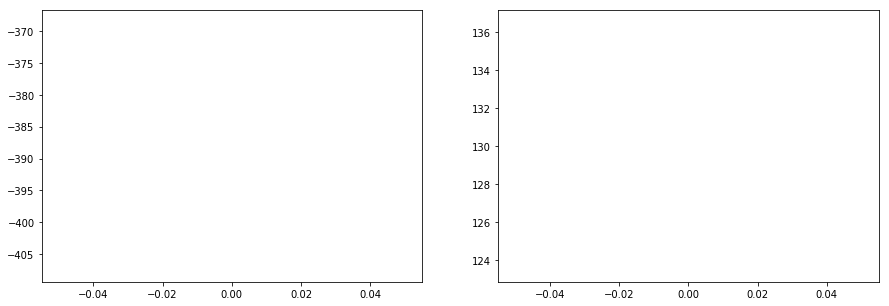

In [55]:
train_agent(episodes_to_run=1, debug=True)

In [ ]:
episodes, scores, timesteps = train_agent(episodes_to_run=2000, episode_info_frequency=50)

episode: 0   score: -607   timesteps: 137   memory length: 137   epsilon: 0.986393417904968   last 200 std dev: 0.0
episode: 50   score: 852   timesteps: 125   memory length: 2000   epsilon: 0.5315808373046328   last 200 std dev: 287.9634492377215
episode: 100   score: 766   timesteps: 116   memory length: 2000   epsilon: 0.29724457327852966   last 200 std dev: 339.2586730078654
episode: 150   score: 1230   timesteps: 109   memory length: 2000   epsilon: 0.16641010920607982   last 200 std dev: 449.3012816389269
episode: 200   score: 1568   timesteps: 130   memory length: 2000   epsilon: 0.09282864613726323   last 200 std dev: 505.1573567711352


/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (104.977571). Check your callbacks.
  % delta_t_median)


episode: 250   score: 2006   timesteps: 114   memory length: 2000   epsilon: 0.051267410581065466   last 200 std dev: 441.6351666251228
episode: 300   score: 2069   timesteps: 115   memory length: 2000   epsilon: 0.0278812739524492   last 200 std dev: 355.61483433625204
episode: 350   score: 1849   timesteps: 122   memory length: 2000   epsilon: 0.015353681447363094   last 200 std dev: 296.9737290990568
episode: 400   score: 2075   timesteps: 117   memory length: 2000   epsilon: 0.008425436449420308   last 200 std dev: 241.68053107356414
episode: 450   score: 2491   timesteps: 166   memory length: 2000   epsilon: 0.004444890698866177   last 200 std dev: 237.21063298258784
episode: 500   score: 2068   timesteps: 122   memory length: 2000   epsilon: 0.002215892548980339   last 200 std dev: 224.30065626297218
episode: 550   score: 2447   timesteps: 120   memory length: 2000   epsilon: 0.0011995605471116525   last 200 std dev: 215.72917506679525
episode: 600   score: 2509   timesteps: 119 

In [53]:
last_200_scores = scores[-200:]
# np.mean(zscore(last_200_scores))
np.std(scores[-200:])

248.3590795602206

In [19]:
printnp.sum([3, -35, 24, -3, 12, 12, 12, -21, 8, -23, -3, 12, 40, 26, 0, 20, 19, -21, 7, 6, -1, 20, -16, 4, 19, 32, 24, 8, 6, -36, 20, 24, 16, 8, -5, 8, -5, -40, 16, 24, -16, 24, 11, -2, 32, 3, 20, 0, -20, -45, 22, 12, 14, -23, -5, 20, 19, 24, -5, -1, -23, 21, -7, 6, 1, -11, 24, 28, -5, 8, 32, -5, -9, 16, 16, 28, -24, -5, -5, -5, -5, 7, -1, -16, 36, 24, 3, 20, 12, 28, -12, 2, -3, -6, -14, 12, -10, -5, 12, 1, -21, 12, -11, -1, -1, -6, 12, 40, 14, 23])


532

### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [29]:
time = np.arange(0,100000)
epsilon_min=0
epsilon_max=1
epsilon_decay=-0.0001

epsilons = []
random_actions = []

for i in range(0,100000):
    epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(epsilon_decay*i)
    if np.random.rand() <= epsilon:
        action = 1
    else:
        action = 0
    epsilons.append(epsilon)
    random_actions.append(action)

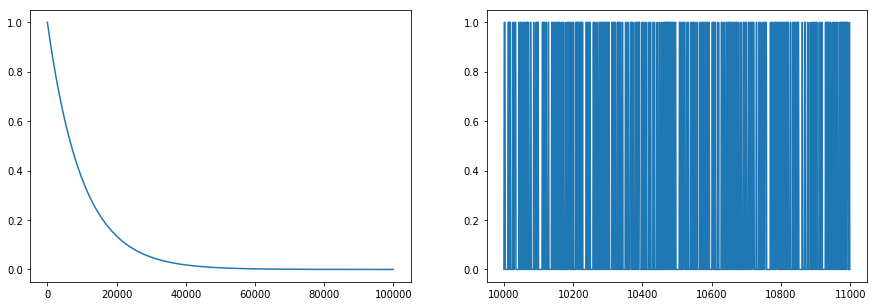

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(time, epsilons)
plt.subplot(122)
plt.plot(time[10000:11000], random_actions[10000:11000])
plt.show()

In [66]:
random_actions[99000:1000000]

[1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
